In [259]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import h5py as hf
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Dataset: using only reprensatations, only in the g r i bands for now

## Getting reps for lenses and non lenses

In [789]:
all_reps['dec']

<HDF5 dataset "dec": shape (6650000,), type "<f8">

In [785]:
# 1. get a lens cutout given ra,dec
# 2. get representation
# 3. Do self-similarity search

#representations of 6.5 million sources
reps_dir = './'
reps_file = 'unions_simCLR_CFISr_HSCg_PS1i.h5'

#representations
all_reps = hf.File(reps_dir+reps_file, 'r')
all_reps.keys()

#candidate lenses in survey
lenses_in_survey = pd.read_csv('./lenses_in_survey.csv', dtype={'Tile':str} )
lenses_in_survey.head()



,Unnamed: 0.1,Unnamed: 0,Names,RA,DEC,Classification,Tile,X,Y,band_nb,bands_list
0,0,1,HSCJ115252+004733†,178.218,0.793,1.3900,356.182,tbd,tbd,1,u
1,1,7,HSCJ223406+012057,338.529,1.349,1.2400,677.183,tbd,tbd,1,u
2,2,8,HSCJ222801+012805,337.008,1.468,1.6000,674.183,tbd,tbd,1,u
3,3,13,HSCJ224221+001144,340.590,0.196,1.4100,681.180,tbd,tbd,1,u
4,4,14,HSCJ223359+015826,338.500,1.974,0.8500,677.184,tbd,tbd,1,u


In [762]:
# Now we want to find ra-dec. The resolution is 0.187 arcsecond/pixel for the CFHT (https://www.cfht.hawaii.edu/Science/CFIS/)
# Our cutouts are 100 pixel wide so 50 on either side --> 
arcsec2deg = 0.000277778
d = 0.187*25*arcsec2deg

print('{} is our margin of error for ra and dec shifts'.format(d))

#in the survey, we have these lenses:
lens_ra  = [list(lenses_in_survey[lenses_in_survey.Tile == tile].RA)[0] for tile in tiles_overlap]
lens_dec = [list(lenses_in_survey[lenses_in_survey.Tile == tile].DEC)[0] for tile in tiles_overlap]  

#ranges
upper_ra = np.array(lens_ra) + d
lower_ra = np.array(lens_ra) - d

upper_dec = np.array(lens_dec) + d
lower_dec = np.array(lens_dec) - d

0.00129861215 is our margin of error for ra and dec shifts


In [763]:
#we found the overlapping tiles to be
ra = all_reps['ra'][:]
dec = all_reps['dec'][:]
tiles_encoded = all_reps['tile'][:]

tiles = [tile.decode("utf-8") for tile in tiles_encoded]
        
tiles_survey = set(list(lenses_in_survey['Tile']))
tiles_rep = set(list(tiles))
tiles_overlap =list(tiles_survey & tiles_rep )
print('{} tiles overlap'.format(len(tiles_overlap)))

ra_rep = all_reps['ra'][:]
dec_rep = all_reps['dec'][:]
tiles_encoded = all_reps['tile'][:]

tile_rep = [tile.decode("utf-8") for tile in tiles_encoded]

count = 0
correspondance_ra_dec = []
lens_reps = []

for i,ra in enumerate(ra_rep):
    dec = dec_rep[i]
    if tile_rep[i] in tiles_overlap: #look only at one of the 98 overlapping tiles
        for j in range(len(lens_ra)): #check if it corresponds to a lens's coord
            if ra <= upper_ra[j] and ra >= lower_ra[j] and dec <= upper_dec[j] and dec >= lower_dec[j] :
                count += 1
                correspondance_ra_dec.append([tile_rep[i], ra,dec])
                lens_reps.append(all_reps['simclr_reps'][i])
                print('found one!! : ', ra, dec)
                break 

98 tiles overlap
found one!! :  129.2740349 31.2233395
found one!! :  27.0905517 33.4052789
found one!! :  125.3778121 37.5585529
found one!! :  140.3866048 36.6203287
found one!! :  140.3877956 36.6214804
found one!! :  134.0090622 39.6871286
found one!! :  148.1675703 34.5794813
found one!! :  29.4733792 32.2598359
found one!! :  148.7716434 30.5417979
found one!! :  144.4243004 31.4659866
found one!! :  354.5521672 30.2242603
found one!! :  149.0556266 32.129405
found one!! :  145.4503239 40.0180153
found one!! :  132.0260076 33.6273957
found one!! :  148.3996335 31.5441323
found one!! :  148.3985766 31.5437435
found one!! :  133.3974865 35.4473314
found one!! :  30.7320142 30.0943373
found one!! :  146.0493641 32.3440817
found one!! :  130.6484226 30.3673943
found one!! :  121.3788839 38.1565496
found one!! :  145.3904313 34.3537773
found one!! :  129.2002418 31.5053898
found one!! :  33.0826121 30.5530036
found one!! :  358.5128167 34.5546275
found one!! :  358.513035 34.5535633
f

In [707]:
tile, lens_ra, lens_dec = zip(*correspondance_ra_dec)
corr_tiles = list(tile)

#select only lenses with nice arcs
arcs_indices = [6,8,18,19,26,27,32,34,36,39,41]

#now modify all arrays to correspond to this:
corr_tiles= [corr_tiles[i] for i in arcs_indices]
lens_ra = [lens_ra[i] for i in arcs_indices]
lens_dec = [lens_dec[i] for i in arcs_indices]
lens_reps = [lens_reps[i] for i in arcs_indices]

In [764]:
lens_rep = np.array(lens_reps)

# Dataset
## 1 : lens, 0: nonlens

In [793]:
indices_nonlenses = np.random.randint(1, 6650000,300)
nonlens_reps = [all_reps['simclr_reps'][i] for i in indices_nonlenses] 

In [794]:
nl = len(lens_reps)
nnl = len(nonlens_reps)
print('{} lenses and {} nonlenses'.format(nl,nnl))


42 lenses and 300 nonlenses


In [795]:
BATCH_SIZE = 2
N_EPOCH = 100

In [796]:
#dataset
X = np.concatenate((lens_reps, nonlens_reps))
Y = np.array([1]*nl+[0]*nnl)

#shuffle
index_shuffle = np.arange(nl+nnl)
np.random.shuffle(index_shuffle)
X = X[index_shuffle]# can normalize with: normalize(X,axis=1)
Y = Y[index_shuffle]

#turn into tensor
X.reshape(X.shape[1],X.shape[0])
#Y.expand_dims(Y, 1)

X= torch.from_numpy(X).type(torch.FloatTensor)
 
Y = torch.from_numpy(Y).type(torch.FloatTensor)

#transforming y labels to hot label
one_hot_label = torch.nn.functional.one_hot(Y.to(torch.int64), 2)
Y = one_hot_label.float()


#train, test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=60)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([229, 2048]) torch.Size([229, 2])
torch.Size([113, 2048]) torch.Size([113, 2])


In [797]:
from torch.utils.data import Dataset, DataLoader


class TimeSeriesDataSet(Dataset):
    """
    This is a custom dataset class. It can get more complex than this, but simplified so you can understand what's happening here without
    getting bogged down by the preprocessing
    """
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if len(self.X) != len(self.Y):
            raise Exception("The length of X does not match the length of Y")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
        _x = self.X[index]
        _y = self.Y[index]

        return _x, _y


params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 6}
    


In [798]:
train_generator = DataLoader(TimeSeriesDataSet(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)


# Architecture of the classifier

In [799]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim=2048, output_dim=2):
        super(LinearClassifier,self).__init__()
        self.linear  = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.linear(x)
        return torch.nn.functional.sigmoid(x)

# Training

In [800]:
#to use the LBFGS optimizer, need <closure>
def fclosure():
        output = model(x)
        optimizer.zero_grad()
        loss=criterion(output, y)
        loss.backward(retain_graph=True)
        return loss


In [801]:
model = LinearClassifier()
relative_weights = torch.tensor([nl/nnl,nl/nl]) #https://datascience.stackexchange.com/questions/48369/what-loss-function-to-use-for-imbalanced-classes-using-pytorch
print(relative_weights)
criterion = torch.nn.BCEWithLogitsLoss(weight = relative_weights) 
optimizer = torch.optim.LBFGS(model.parameters(), lr = 0.01) #is the one they use in the paper #torch.optim.SGD(model.parameters(),lr = 0.1)


all_loss = []
for epoch in range(N_EPOCHS):
    temp_loss = []
    for x, y in train_generator:
        loss = optimizer.step(fclosure)
        temp_loss.append(loss.item())
        
    all_loss.append(np.mean(temp_loss))
    #print(f"Epoch: {epoch}, loss: {np.mean(temp_loss)}")

tensor([0.1400, 1.0000])


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


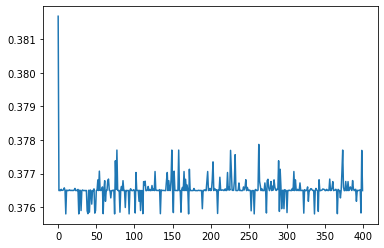

In [802]:
plt.plot(all_loss)

# Testing

In [803]:
model.eval()
label_pred = model.forward(X_test)
label_pred = label_pred.detach().numpy()
lens_preds = [(i,label_pred[i,1]) for i,y in enumerate(Y_test[:,1]) if y == 1 ]

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0, 0.5, 'score')

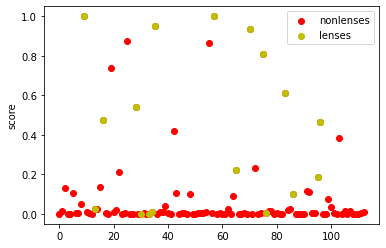

In [804]:
plt.scatter(range(len(label_pred)),label_pred[:,1], c = 'r')
for x in lens_preds:
    plt.scatter(x[0],x[1],c = 'y')
plt.legend({'nonlenses':'r', 'lenses':'y'})
plt.ylabel('score')

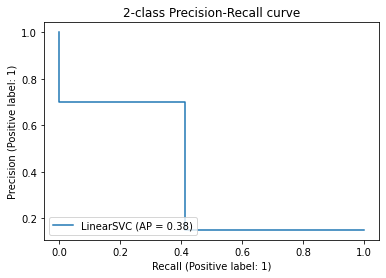

In [805]:
from sklearn.metrics import PrecisionRecallDisplay

y_pred = [0 if label < 0.5 else 1 for label in label_pred[:,1] ]
y_true = Y_test[:,1]

display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
#confusion
nb_classes = 1

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)